In [1]:
import numpy as np
import pickle as pkl
from Extractor import Extractor
from scipy.sparse import coo_matrix,csr_matrix
#import tensorflow as tf
import torch
from utils import *
import networkx as nx
from matplotlib import pyplot as plt
from model import *
from train import *

from explain import *
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import sys

np.set_printoptions(threshold=sys.maxsize)
dataset_name = 'syn3'

In [2]:
1 <  float('inf')

True

In [3]:
class Tree_Cycles_Dataset(Dataset):
    def __init__(self, root, transform = None, pre_transform = None, subgraph = False, remap=False):
        super(Tree_Cycles_Dataset, self).__init__(root, transform, pre_transform)
        self.root = root
        self.subgraph = subgraph
        self.remap = remap
        

        with open(os.path.join(self.root, 'syn4.pkl'), 'rb') as fin:
            self.adj, self.features, self.y_train, self.y_val, self.y_test, self.train_mask, self.val_mask, self.test_mask, self.edge_label_matrix  = pkl.load(fin)
        self.hops = 3
        self.all_label = np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test))
        self.single_label = np.argmax(self.all_label,axis=-1)
        self.allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] ==1]
        self.csr_adj = csr_matrix(self.adj)
        self.extractor = Extractor(self.csr_adj,self.features,self.edge_label_matrix,self.all_label,self.hops)            
    @property
    def num_features(self):
        return 10
    @property
    def num_classes(self):
        return 2

    def get_subgraph(self, idx):
        #if self.subgraph:
        idx = self.allnodes[idx] if self.remap else idx
        sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.extractor.subgraph(idx)
        return sub_adj,sub_feature, sub_label,sub_edge_label_matrix
        #else:
        #    return None
    def len(self):
        if self.subgraph:
            if not self.remap:
                return len(self.single_label)
            return len(self.allnodes)
        else:
            return 1
    
    def get(self, idx):
        if self.subgraph:
            if self.remap:
                idx = self.allnodes[idx]
            sub_adj,sub_feature, sub_label,sub_edge_label_matrix = self.extractor.subgraph(idx)
            edge_index = torch.tensor(preprocess_adj(sub_adj)[0].T, dtype = torch.long)
            x = torch.tensor(sub_feature).float()
            y = torch.argmax(torch.tensor(sub_label, dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        else:

            edge_index = torch.tensor(preprocess_adj(self.adj)[0].T, dtype = torch.long)
            x = torch.tensor(self.features).float()
            y = torch.argmax(torch.tensor(np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test)), dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        return data

In [4]:
class BA_Shape_Dataset(Dataset):
    def __init__(self, root, name, setting=1, hops=3, transform = None, pre_transform = None, subgraph = False, remap=False):
        super(BA_Shape_Dataset, self).__init__(root, transform, pre_transform)
        self.root = root
        self.subgraph = subgraph
        self.remap = remap
        self.name = name
        self.setting =setting
        with open(os.path.join(self.root, name + '.pkl'), 'rb') as fin:
            self.adj, self.features, self.y_train, self.y_val, self.y_test, self.train_mask, self.val_mask, self.test_mask, self.edge_label_matrix  = pkl.load(fin)
        self.hops = hops

        self.all_label = np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test))
        self.single_label = np.argmax(self.all_label,axis=-1)
        #self.allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0] #[i for i in range(400,700,5)]
        self.csr_adj = csr_matrix(self.adj)
        self.extractor = Extractor(self.csr_adj,self.features,self.edge_label_matrix,self.all_label,self.hops)            
    @property
    def num_features(self):
        return 10
    @property
    def num_classes(self):
        return self.all_label.shape[1]

    @property 
    def allnodes(self):
        if self.setting==1:
            if self.name=='syn3':
                allnodes = [i for i in range(511,871,6)]
            elif self.name=='syn4':
                allnodes = [i for i in range(511,800,1)]
            else:
                allnodes = [i for i in range(400,700,5)] # setting from their original paper
        elif self.setting==2:
            allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] ==1]
        elif self.setting==3:
            if self.name == 'syn2':
                allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0 and self.single_label[i] != 4]
            else:
                allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0]
        return allnodes

    def set_hops(self, hops=3):
        self.hops = hops
        self.extractor = Extractor(self.csr_adj,self.features,self.edge_label_matrix,self.all_label,self.hops)  

    def get_subgraph(self, idx):
        #if self.subgraph:
        idx = self.allnodes[idx] if self.remap else idx
        sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.extractor.subgraph(idx)
        return sub_adj,sub_feature, sub_label,sub_edge_label_matrix
        #else:
        #    return None
    def len(self):
        if self.subgraph:
            if not self.remap:
                return len(self.single_label)
            return len(self.allnodes)
        else:
            return 1
    
    def get(self, idx):
        if self.subgraph:
            if self.remap:
                idx = self.allnodes[idx]
            sub_adj,sub_feature, sub_label,sub_edge_label_matrix = self.extractor.subgraph(idx)
            edge_index = torch.tensor(preprocess_adj(sub_adj)[0].T, dtype = torch.long)
            x = torch.tensor(sub_feature).float()
            y = torch.argmax(torch.tensor(sub_label, dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        else:

            edge_index = torch.tensor(preprocess_adj(self.adj)[0].T, dtype = torch.long)
            x = torch.tensor(self.features).float()
            y = torch.argmax(torch.tensor(np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test)), dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        return data

In [5]:
class ATTGCN_Node(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, num_features = None):
        super(ATTGCN_Node, self).__init__()
        num_features = dataset.num_features if num_features is None else num_features
        
        self.conv1 = CD_GCNConv(num_features, hidden)
       
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(CD_GATConv(in_channels = hidden, out_channels = (int)(hidden/1), heads=1))
        
        self.lin1 = CD_Linear(hidden, hidden)
        
        self.lin2 = CD_Linear(hidden, dataset.num_classes)
        
    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data, CD_explain: bool = False, mask_index = None):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if CD_explain:
            x = mask_x(x, mask_index)
        x = CD_relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = CD_relu(conv(x, edge_index))
        #x = CD_global_max_pool(x, batch)
        #x = CD_feature_max_pool(x, batch)
        #print(x.shape)
        x = CD_relu(self.lin1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        if CD_explain:
            return x
        else:
            return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [6]:
dataset = Tree_Cycles_Dataset(root = './dataset')

explainer


In [7]:
dataset = BA_Shape_Dataset(root = './dataset', name = 'syn4', setting = 3, hops=3)

explainer


In [13]:
gcn_model = GCN_Node(dataset, 3, 20)

In [14]:
dataset.setting = 3
dataset.subgraph = False
dataset.remap = True
#train(gcn_model, dataset, max_epoch=1000, lr=0.005, train_batch_size = 1024, temp_name = 'community_temp')
node_pred_task_train(gcn_model, dataset, max_epoch=1000, lr=0.005, temp_name='grid_temp', train_rate = 0.90)

prepare dataloader
done
Epoch:  0 Avg loss:  0.7022877 ; acc:  0.4137308 ; epoch time:  0.3391761779785156
eval test...
test acc:  0.42741933
test loss:  0.70103496
saving...


Epoch:  1 Avg loss:  0.69101644 ; acc:  0.5862692 ; epoch time:  0.34851765632629395
eval test...
test acc:  0.57258064
test loss:  0.6909778
saving...


Epoch:  2 Avg loss:  0.683832 ; acc:  0.5862692 ; epoch time:  0.3452157974243164
eval test...
test acc:  0.57258064
test loss:  0.6847662
saving...


Epoch:  3 Avg loss:  0.6789818 ; acc:  0.5862692 ; epoch time:  0.3417525291442871
eval test...
test acc:  0.57258064
test loss:  0.68095934
saving...


Epoch:  4 Avg loss:  0.6764449 ; acc:  0.5862692 ; epoch time:  0.31671619415283203
eval test...
test acc:  0.57258064
test loss:  0.6795286
saving...


Epoch:  5 Avg loss:  0.67687815 ; acc:  0.5862692 ; epoch time:  0.3274970054626465
eval test...
test acc:  0.57258064
test loss:  0.68111384


Epoch:  6 Avg loss:  0.67921513 ; acc:  0.5862692 ; epoch time:  0.3

KeyboardInterrupt: 

In [10]:
dataset.subgraph = True
dataset.remap = True
train(gcn_model, dataset, max_epoch=3000, lr=0.005)

prepare dataloader
done
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7bcbb66ef0>
Traceback (most recent call last):
  File "/home/nightknight/anaconda3/envs/graph/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7bcbb66ef0>
    Traceback (most recent call last):
Exception ignored in:   File "/home/nightknight/anaconda3/envs/graph/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7bcbb66ef0>

      File "/home/nightknight/anaconda3/envs/graph/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Traceback (most recent call last):
self._shutdown_workers()  File "/home/nightknight/anaconda3/envs/graph/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__

  File "/home

KeyboardInterrupt: 

In [15]:
gcn_model = torch.load('./checkpoint/grid_temp')

In [16]:
dataset.subgraph = False
dataset.remap = False
eval(gcn_model, dataset)

Epoch:  0 Avg loss:  0.41243014 ; acc:  0.77822906 ; epoch time:  0.029079437255859375


array(0.77822906, dtype=float32)

In [27]:
dataset.setting = 3
correct = 0
dataset.subgraph = True
dataset.remap = True
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model = gcn_model
load_model.eval()
in_correct = []
for idx in range(dataset.len()):
    print('index: ', idx)
    data = get_data(dataset, idx).to('cuda')
    pred = load_model.forward(data)
    #print(preds)
    label = data.y.to('cuda')

    _, indices = torch.max(pred, 1)
    #print(pred)
    print(label)
    print(torch.sum(label))
    print(indices)
    #print(torch.argmax(load_model(data)[0]))
    if (indices[0] == 1.0):
        correct += 1
    else:
        in_correct.append(idx)
        print(in_correct)
print(correct)

index:  0
tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
index:  1
tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(9, device='cuda:0')
tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
index:  2
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
index:  3
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(9, device='cuda:0')
tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
index:  4
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(9, device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
[4]
index:  5
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(9, device='cuda:0')
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
index:  6
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0

KeyboardInterrupt: 


index:  0
target node:  0
epoch time:  0.10573625564575195
{0, 2, 4, 6, 11, 12, 13, 14}
acc:  0.625
auc:  0.7142857142857143
mean acc:  0.625
mean auc:  0.7142857142857143

index:  1
target node:  0
epoch time:  0.07853150367736816
{0, 2, 4, 6, 7, 8, 9, 10, 11}
acc:  0.8888888888888888
auc:  0.962962962962963
mean acc:  0.7569444444444444
mean auc:  0.8386243386243386

index:  2
target node:  0
epoch time:  0.06259751319885254
{0, 2, 3, 4, 5, 6, 7, 8}
acc:  1.0
auc:  1.0
mean acc:  0.8379629629629629
mean auc:  0.892416225749559

index:  3
target node:  0
epoch time:  0.07952666282653809
{0, 1, 4, 6, 7, 8, 9, 10, 11}
acc:  0.8888888888888888
auc:  0.962962962962963
mean acc:  0.8506944444444444
mean auc:  0.91005291005291

index:  5
target node:  0
epoch time:  0.06253337860107422
foo

index:  6
target node:  0
epoch time:  0.06470274925231934
{0, 2, 3, 4, 5, 6, 7, 8}
acc:  1.0
auc:  1.0
mean acc:  0.8805555555555555
mean auc:  0.928042328042328

index:  7
target node:  0
epoch time: 

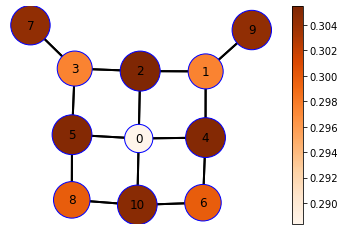

mean acc:  0.8697573561703996
mean auc:  0.8529135819896692

index:  77
target node:  0
epoch time:  0.18578767776489258
foo

index:  78
target node:  0
epoch time:  0.16635441780090332
{0, 1, 2, 3, 4, 5, 6, 7}
acc:  1.0
auc:  1.0
mean acc:  0.8725284762518805
mean auc:  0.856043080245208

index:  79
target node:  0
epoch time:  0.16893935203552246
foo

index:  80
target node:  0
epoch time:  0.1692187786102295
{0, 1, 2, 3, 4, 5, 6, 8}
acc:  1.0
auc:  1.0
mean acc:  0.8751841329966331
mean auc:  0.8590421827400995

index:  81
target node:  0
epoch time:  0.22234010696411133
{0, 1, 5, 6, 7, 8, 10, 12}
acc:  0.375
auc:  0.3375
mean acc:  0.8649762935477222
mean auc:  0.8483984647249954

index:  82
target node:  0
epoch time:  0.20157790184020996
{0, 1, 4, 5, 6, 7, 8, 10, 11}
acc:  1.0
auc:  1.0
mean acc:  0.8676767676767677
mean auc:  0.8514304954304954

index:  83
target node:  0
epoch time:  0.18559718132019043
{0, 1, 2, 3, 4, 5, 7, 8}
acc:  1.0
auc:  1.0
mean acc:  0.8702713408595762


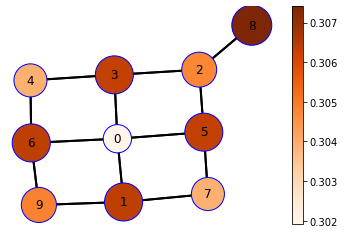

mean acc:  0.8730703259005146
mean auc:  0.8409721655004674

index:  86
target node:  0
epoch time:  0.1869187355041504
foo

index:  87
target node:  0
epoch time:  0.19365382194519043
{0, 1, 2, 3, 4, 5, 6, 8}
acc:  1.0
auc:  1.0
mean acc:  0.8754208754208754
mean auc:  0.8439171253986069

index:  88
target node:  0
epoch time:  0.20117759704589844
foo

index:  89
target node:  0
epoch time:  0.2088925838470459
foo

index:  90
target node:  0
epoch time:  0.2705538272857666
{0, 1, 3, 5, 11, 13, 16, 17}
acc:  0.375
auc:  0.3375
mean acc:  0.8663223140495868
mean auc:  0.8347095413004504

index:  91
target node:  0
epoch time:  0.24340009689331055
{0, 1, 2, 3, 6, 8, 9, 11, 12}
acc:  1.0
auc:  1.0
mean acc:  0.8687094155844157
mean auc:  0.8376611566343709

index:  92
target node:  0
epoch time:  0.19418883323669434
{0, 1, 2, 3, 4, 6, 7, 8}
acc:  1.0
auc:  1.0
mean acc:  0.871012759170654
mean auc:  0.8405092065179784

index:  93
target node:  0
epoch time:  0.22034883499145508
{0, 1, 2, 

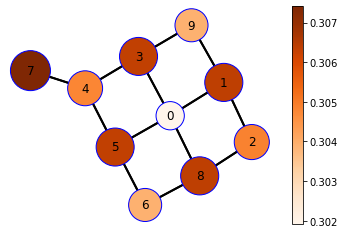

mean acc:  0.873501968840952
mean auc:  0.8289665215512673

index:  95
target node:  0
epoch time:  0.195723295211792
foo

index:  96


KeyboardInterrupt: 

In [28]:
acc_list = []
auc_list = []
node_num_list = []
dataset.subgraph = True
dataset.remap = True
load_model = gcn_model
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
#load_model.eval()

all_node_label = []
all_node_color = []
for idx in range(dataset.len()):
    if idx in in_correct:
        continue
    print('\nindex: ', idx)
    sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
    #truth_node = np.where(sub_label[:,1] == True)[0]
    truth_node = get_node_set(sub_edge_label_matrix)
    #if len(truth_node) > 6:
    #    continue
    node_sort, node_color = print_explain(dataset, load_model, idx, class_idx = 1, visible = False)

    node_label = np.array([0] * sub_label.shape[0])
    node_label[list(truth_node)] = 1
    pred  = np.array([0] * sub_label.shape[0])
    pred[node_sort[:6]] = 1
    
    edge_label = []
    edge_pred = []
    for r,c in list(zip(sub_adj.row,sub_adj.col)):
        sub_edge_label = sub_edge_label_matrix.todense()
        edge_label.append(sub_edge_label[r,c] or sub_edge_label[c,r])
        edge_pred.append((node_color[r] + node_color[c])/2)
    #print(edge_label)
    try:
        auc = roc_auc_score(node_label, node_color)
    except:
        print('foo')
        continue
        auc = 1.0
    #auc = 1.0 if len(label) == 6 else roc_auc_score(edge_label, edge_pred)
    #auc = roc_auc_score(label, node_color)
    node_num_list.append(len(truth_node))

    #print(edge_label)
    #print(edge_pred)
    print(truth_node)
    #print(node_sort)
    acc = len([node for node in node_sort[:len(truth_node)] if node in truth_node])/len(truth_node)
    acc_list.append(acc)
    auc_list.append(auc)
    all_node_label.extend(node_label)
    all_node_color.extend(node_color)
    print('acc: ', acc)
    print('auc: ', auc)
    if auc == 0.0:
        print_explain(dataset, load_model, idx, class_idx = 0, visible = True)
    print('mean acc: ', np.mean(acc_list))
    print('mean auc: ', np.mean(auc_list))

In [26]:
np.argmax(sub_label,axis=-1)[0]

1

In [8]:
torch.save(gcn_model, './checkpoint/gcn_grid')

In [26]:
data = get_data(dataset, 0).to('cuda')
preds = load_model.forward(data)
_, indices = torch.max(preds, 1)
indices.shape

torch.Size([1231])

In [28]:
acc_list = []
auc_list = []

dataset.subgraph = False
dataset.remap = False
dataset.setting=1
load_model = gcn_model
#load_model = torch.load('./checkpoint/community_temp')
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model.eval()

all_node_label = []
all_node_color = []
for idx in dataset.allnodes:
    #idx = 519
    print('\nindex: ', idx)
    sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
    #truth_node = np.where(sub_label[:,1] == True)[0]
    truth_node = list(get_node_set(sub_edge_label_matrix))
    
    class_idx = np.argmax(sub_label[0],axis=-1)
    print('0 label: ', class_idx)
    if indices[idx] != class_idx:
        print('================ incorrect pred =====================')
        continue
    node_range = dataset.extractor.nodes
    print('node range: ', node_range)
    node_sort, node_color = print_subgraph_explain(dataset = dataset, model = load_model, idx = 0, class_idx = class_idx, visible = False, figsize = (12,9), node_range = node_range)
    print(node_color)
    print(node_sort)

    node_label = np.array([0] * sub_label.shape[0])
    #node_label[list(truth_node)] = 1
    # find truth node, far node is not real truth
    for n in truth_node:
        if abs((node_range[n] - node_range[0])) <= 9:
            node_label[n] = 1
    #        print(n)
    if np.sum(node_label) > 9: node_sort, node_color = print_subgraph_explain(dataset = dataset, model = load_model, idx = 0, class_idx = class_idx, visible = True, figsize = (12,9), node_range = node_range)
    try:
        auc = roc_auc_score(node_label, node_color)
    except:
        print('foo')
        continue
        auc = 1.0

    print("truth node: ", truth_node)
    #print(node_sort)
    acc = len([node for node in node_sort[:9] if node in truth_node])/9
    acc_list.append(acc)
    auc_list.append(auc)
    #all_node_label.extend(node_label)
    #all_node_color.extend(node_color)
    print('acc: ', acc)
    print('auc: ', auc)
    #if acc == 0.0:
    #    print(node_sort)
    #    print_explain(dataset, load_model, idx, class_idx = np.argmax(sub_label[0],axis=-1), visible = True)
    print('mean acc: ', np.mean(acc_list))
    print('mean auc: ', np.mean(auc_list))
    #break


index:  511
0 label:  1
node range:  [511, 0, 513, 1, 515, 2, 517, 3, 4, 5, 6, 514, 516, 518, 512]
target node:  511
epoch time:  0.1514291763305664
[0.3567338287830353, 0.3511389195919037, 0.3397960364818573, 0.33758512139320374, 0.3432352840900421, 0.3375582993030548, 0.3397960364818573, 0.33220475912094116, 0.33220475912094116, 0.3321780562400818, 0.33189839124679565, 0.3538082242012024, 0.3374482989311218, 0.33744826912879944, 0.3538082242012024]
[ 0 14 11  1  4  6  2  3  5 12 13  8  7  9 10]
truth node:  [0, 2, 4, 6, 11, 12, 13, 14]
acc:  0.6666666666666666
auc:  0.8392857142857143
mean acc:  0.6666666666666666
mean auc:  0.8392857142857143

index:  512
0 label:  1
node range:  [512, 0, 514, 1, 516, 2, 518, 513, 515, 517, 519, 511]
target node:  512
epoch time:  0.10879039764404297
[0.35748448967933655, 0.33776551485061646, 0.34387099742889404, 0.332610547542572, 0.34707242250442505, 0.332610547542572, 0.3361215889453888, 0.35763439536094666, 0.3543564975261688, 0.338042706251144

In [8]:
data = get_data(dataset, 0).to('cuda')

In [14]:
data

Batch(batch=[1231], edge_index=[2, 3130], x=[1231, 10], y=[1231])

In [15]:
gcn_model(data)

tensor([[-1.3405, -0.3034],
        [-1.3357, -0.3051],
        [-1.4081, -0.2805],
        ...,
        [-1.3386, -0.3041],
        [-1.2692, -0.3300],
        [-1.4808, -0.2581]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [23]:
CD_explain(model = gcn_model, dataset = dataset, idx = 0, node_range = node_range)

target node:  519
[[519], [512], [513], [514], [515], [516], [517], [518]]


{0: {'rel': [nan, nan, nan, nan, nan, nan, nan, nan],
  'irrel': [nan, nan, nan, nan, nan, nan, nan, nan]},
 1: {'rel': [nan, nan, nan, nan, nan, nan, nan, nan],
  'irrel': [nan, nan, nan, nan, nan, nan, nan, nan]}}

In [17]:
node_range

[519, 512, 513, 514, 515, 516, 517, 518]

In [9]:
def CD_explain(model, dataset, idx = 0, mask_node_list = None, node_range = None, target_node = None):
    """
    idx: idx of graph to explain
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    data = get_data(dataset, idx)
    data = data.to(device)
    

    mask_list = []
    # generate mask
    node_range = range(data.x.shape[0]) if node_range is None else node_range
    target_node = target_node if target_node is not None else node_range[0]
    '''
    for i in range(node_range):
        # generate data idx mask to check
        mask_index = [0] * data.x.shape[0]
        mask_index[i] = 1
     b mask_node_list is not None and i in mask_node_list:
            for n in mask_node_list:
                print(i)
                print(mask_node_list)
                mask_index[n] = 1
        mask_list.append(mask_index)
    '''

    for i in node_range:
        if mask_node_list is not None and i in mask_node_list:
            mask_list.append(mask_node_list)
        else:
            mask_list.append([i])
    # forward to explain according to mask list
    print('target node: ', target_node)
    print(mask_list)
    class_score = get_score(model = model, data = data, input_mask_list = mask_list, target_node = target_node)
    return class_score

In [49]:
mask_index = [0] * 1231
mask_index[513] = 0
preds = gcn_model.forward(data, CD_explain=True, mask_index = mask_index)
preds['irrel'][519]

tensor([-0.4491,  1.1768], device='cuda:0', grad_fn=<SelectBackward>)

In [12]:
gcn_model.to('cuda')
get_score(gcn_model, data, input_mask_list = [[519]], softmax = True, target_node = 519)

(tensor([], device='cuda:0', dtype=torch.int64), tensor([], device='cuda:0', dtype=torch.int64))
(tensor([], device='cuda:0', dtype=torch.int64), tensor([], device='cuda:0', dtype=torch.int64))
out1:  tensor([[-0.7417, -0.7377, -0.8229,  ..., -0.7401, -0.6534, -1.2926],
        [ 0.6840,  0.6797,  0.7706,  ...,  0.6823,  0.5898,  1.2729]],
       device='cuda:0', grad_fn=<AddBackward0>)
out max:  tensor(5.3361, device='cuda:0', grad_fn=<MaxBackward1>)
out2:  tensor([[-6.0778, -6.0737, -6.1590,  ..., -6.0762, -5.9895, -6.6286],
        [-4.6521, -4.6564, -4.5654,  ..., -4.6538, -4.7463, -4.0632]],
       device='cuda:0', grad_fn=<SubBackward0>)
out3:  tensor([[0.0023, 0.0023, 0.0021,  ..., 0.0023, 0.0025, 0.0013],
        [0.0095, 0.0095, 0.0104,  ..., 0.0095, 0.0087, 0.0172]],
       device='cuda:0', grad_fn=<ExpBackward>)
_rel:  tensor([[0.6774, 0.6765, 0.6949,  ..., 0.6770, 0.6578, 0.7846],
        [0.3354, 0.3363, 0.3163,  ..., 0.3357, 0.3567, 0.2188]],
       device='cuda:0', grad_

{0: {'rel': [0.05073805898427963], 'irrel': [0.024297235533595085]},
 1: {'rel': [0.30219730734825134], 'irrel': [0.6227673888206482]}}

In [11]:
def get_score(model, data, input_mask_list, softmax = True, target_node = 0):
    Binary_mask_list = []
    for i in range(len(input_mask_list)):
        mask_index = [0] * data.x.shape[0]
        for m in input_mask_list[i]:
            mask_index[m] = 1
        Binary_mask_list.append(mask_index)
    
    preds_list = []
    model.eval()
    
    for mask_index in Binary_mask_list:
        model.zero_grad()
        preds = model.forward(data, CD_explain=True, mask_index = mask_index)
        #print(preds)
        #print(data.y)
        preds['rel'] = preds['rel'].T
        preds['irrel'] = preds['irrel'].T
        #print(preds['irrel'].shape[0])
        #print(dataset.num_classes)
        print(torch.where(torch.isnan(preds['rel']) == True))
        print(torch.where(torch.isnan(preds['irrel']) == True))
        #print(preds)
        if softmax:
            preds = CD_softmax(preds, index = torch.tensor([0] * preds['irrel'].shape[0]).to(device))
        #print(preds)
        preds_list.append(preds)
        # need to softmax??
        #print('preds shape', preds['rel'].shape)
    # rel cd score for each class
    class_score = {}
    for class_idx in range(preds['irrel'].shape[0]):
        class_score[class_idx] = {}
        class_score[class_idx]['rel'] = []
        class_score[class_idx]['irrel'] = []
        for preds in preds_list:
            class_score[class_idx]['rel'].append((float)((preds['rel'][class_idx][target_node].cpu().detach())))
            class_score[class_idx]['irrel'].append((float)((preds['irrel'][class_idx][target_node].cpu().detach())))
            #class_score[class_idx]['rel'].append((float)((preds['rel'][0][class_idx].cpu().detach())))
            #class_score[class_idx]['irrel'].append((float)((preds['irrel'][0][class_idx].cpu().detach())))

    return class_score

In [10]:
global o

def CD_softmax(src: Tensor, index: Optional[Tensor], ptr: Optional[Tensor] = None,
            num_nodes: Optional[int] = None) -> Tensor:

    cd_explain = isinstance(src, dict)
    if cd_explain:
        out = src['rel'] + src['irrel']
        out_rel = src['rel']
        out_irrel = src['irrel']
        print('out1: ', out)
    else:
        out = src
    
    #print(out.shape)
    global o
    o = out
    print('out max: ', out.max())
    out = out - out.max()
    print('out2: ', out)
    out = out.exp()
    print('out3: ', out)
    if cd_explain:
        _rel = 1.0/(1.0 + (out_irrel - out_rel).exp())
        print('_rel: ', _rel)
        _irrel = 1.0 - _rel
        print('_irrel: ', _irrel)

    if ptr is not None:
        out_sum = gather_csr(segment_csr(out, ptr, reduce='sum'), ptr)
    elif index is not None:
        N = maybe_num_nodes(index, num_nodes)
        out_sum = scatter(out, index, dim=0, dim_size=N, reduce='sum')[index]
    elif index is None:
        index = torch.tensor([0] * out.shape[0])

    else:
        raise NotImplementedError
    
    if cd_explain:
        #print('out: ', out)
        #print('out_sum: ', out_sum)
        return {'rel': (out/(out_sum + 1e-16)) * _rel, 'irrel': (out/(out_sum + 1e-16)) * _irrel}
    else:
        return out / (out_sum + 1e-16)

In [106]:
torch.where(torch.isnan(o) == True)

(tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 tensor([162, 186, 234, 240, 246, 252, 162, 186, 234, 240, 246, 252],
        device='cuda:0'))

In [101]:
o.max()

tensor(nan, device='cuda:0', grad_fn=<MaxBackward1>)